# PREVISÃO DA VELOCIDADE DO VENTO A CURTO PRAZO USANDO REDES NEURAIS QUÂNTICAS EM MUCURI PARA 3 HORAS SIMULTÂNEAS, BAHIA


## Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pennylane as qml
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras import backend, optimizers, activations
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score

from math import sqrt
from scipy import stats
from datetime import datetime,timedelta

tf.keras.backend.set_floatx('float64')

## Carregando os Dados

In [2]:
def carregar_tabela(arquivo):
    # Carregando dataset
    dataset_train = pd.read_csv(arquivo, sep='\t', header = 0)

    # Separando os valores entre dados de entrada e dados a serem preditos 
    # (X e Y) Utilizado apenas a coluna de velocidade e removido o primeiro
    # índice para prever a próxima velocidade
    y_train_all = dataset_train[:].drop(dataset_train.index[0])
    # Remove a ultima linha do X pois não o predito Y não terá uma linha a mais
    X_train_all = dataset_train.iloc[:-3,:]
    

    y_train_all['1h - Vento'] = y_train_all.iloc[:,4].shift(0)
    y_train_all['2h - Vento'] = y_train_all.iloc[:,4].shift(-1)
    y_train_all['3h - Vento'] = y_train_all.iloc[:,4].shift(-2)
    y_train_all = y_train_all.iloc[:-2,-3:]
    
    return X_train_all.iloc[:,-5:],y_train_all['1h - Vento'].values

In [3]:
filename = 'train150_mucuri.txt'

X_train_all,y_train_all = carregar_tabela(filename)
y_train_all = y_train_all.reshape(-1,1)

n_features = X_train_all.shape[1]
n_instances = X_train_all.shape[0]
print(f"There are {n_features} features and {n_instances} instâncias")
X_train_all.head()

There are 5 features and 547 instâncias


,Velocidade,Direção,Temperatura,Umidade,Pressão
0,13.012139,75.105481,27.516129,72.930636,1020.422601
1,12.726087,68.334332,27.238095,75.212121,1020.394348
2,12.081111,64.457865,27.105263,75.741379,1020.508333
3,11.647222,53.842100,26.305556,75.302632,1020.611000
4,11.064444,53.945279,25.464286,76.592593,1020.866500


In [4]:
y_train_all

array([[12.72608696],
       [12.08111113],
       [11.64722224],
       [11.06444444],
       [10.32444445],
       [ 9.86277779],
       [ 9.59888887],
       [ 9.48888888],
       [ 7.50222222],
       [ 7.0811111 ],
       [ 8.00333342],
       [ 8.14944447],
       [ 8.96277779],
       [ 7.6727778 ],
       [ 6.33166668],
       [ 4.5871795 ],
       [ 4.96111111],
       [ 5.65944445],
       [ 5.41777779],
       [ 7.3039106 ],
       [ 8.6027778 ],
       [11.70611108],
       [12.30500005],
       [12.08722222],
       [11.34166668],
       [10.69388894],
       [ 9.51944444],
       [ 8.94000002],
       [ 8.10500002],
       [ 7.63777778],
       [ 6.66111112],
       [ 4.80111111],
       [ 3.71777777],
       [ 2.14166666],
       [ 2.77055556],
       [ 2.74944444],
       [ 3.91222222],
       [ 5.53222223],
       [ 6.35166666],
       [ 4.57777778],
       [ 3.91888887],
       [ 4.28111111],
       [ 3.59999999],
       [ 3.90555555],
       [ 7.15611111],
       [ 8

# Normalizando

In [5]:
scaler_x = MinMaxScaler(feature_range=(-1, 1))
X_train_scaled = scaler_x.fit_transform(X_train_all)

scaler_y = MinMaxScaler(feature_range=(-1, 1))
y_train_scaled = scaler_y.fit_transform(y_train_all)

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X_train_scaled, y_train_scaled, test_size=0.2)
X_train = tf.cast(X_train, dtype=tf.float64)
y_train = tf.cast(y_train, dtype=tf.float64)

# Rede Quântica 

In [7]:
def H_layer(n_qubits):
    for idx in range(n_qubits):
        qml.Hadamard(wires=idx)

def Data_AngleEmbedding_layer(inputs, n_qubits):
    qml.templates.AngleEmbedding(inputs,rotation='Y', wires=range(n_qubits))

def RY_layer(w):
    for idx, element in enumerate(w):
        qml.RY(element, wires=idx)

def ROT_layer(w):
    for i in range(len(w)):
        qml.Rot(*w[i],wires=i)

def strong_entangling_layer(nqubits):
    for i in range(nqubits-1): 
        qml.CNOT(wires=[i, i+1])
    qml.CNOT(wires=[nqubits-1,0])
    
def entangling_layer(nqubits):
    for i in range(0, nqubits - 1, 2): 
        qml.CNOT(wires=[i, i + 1])
    for i in range(1, nqubits - 1, 2):  
        qml.CNOT(wires=[i, i + 1])

In [8]:
n_qubits = n_features
n_layers = 1
#n_layers = np.ceil(np.log(n_features))

#dev = qml.device('default.qubit', wires=n_qubits)
dev = qml.device('lightning.gpu', wires=n_qubits)
@qml.qnode(dev)
def qnode(inputs, weights_1):
    H_layer(n_qubits)
    Data_AngleEmbedding_layer(inputs, n_qubits)
    for k in range(n_layers):
        entangling_layer(n_qubits)
        ROT_layer(weights_1[k])
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

## Drawing Quantum Circuit

In [9]:
weight_shapes = {"weights_1": (n_layers,5,3)}

sampl_weights = np.random.uniform(low=0, high=np.pi, size=weight_shapes["weights_1"])
sampl_input = np.random.uniform(low=0, high=np.pi, size=(5,))
print(qml.draw(qnode, expansion_strategy="device")(sampl_input, sampl_weights))

0: ──H──RY(0.27)─╭●──Rot(3.01,1.61,0.60)──────────────────────┤  <Z>
1: ──H──RY(2.29)─╰X─╭●────────────────────Rot(2.17,2.58,1.00)─┤  <Z>
2: ──H──RY(3.10)─╭●─╰X────────────────────Rot(2.14,2.82,1.64)─┤  <Z>
3: ──H──RY(0.68)─╰X─╭●────────────────────Rot(1.12,2.45,0.06)─┤  <Z>
4: ──H──RY(1.51)────╰X────────────────────Rot(2.79,2.50,1.33)─┤  <Z>


## Creating Quantum Model

In [10]:
q_layer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=n_qubits)
Activation=tf.keras.layers.Activation(activations.linear)
output_layer = tf.keras.layers.Dense(1,kernel_initializer='normal')

opt = tf.keras.optimizers.Adam(learning_rate=0.1)

model = tf.keras.models.Sequential([q_layer,Activation, output_layer])
model.compile(opt, loss="mse")

In [11]:
input_shape = (n_qubits,)

model.build(input_shape)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (5, 5)                    15        
                                                                 
 activation (Activation)     (5, 5)                    0         
                                                                 
 dense (Dense)               (5, 1)                    6         
                                                                 
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


### Criando o Compilador e Executando o treino

<table>
<tr>
    <th><p align="left">Variável</p></th>
    <th><p align="left">Valor</p></th>
<tr>
    <td><p align="left">Loss</p></td>
    <td><p align="left">MSE (Mean Square Error)</p></td>
</tr>
<tr>
    <td><p align="left">Optimizer</p></td>
    <td><p align="left">SGD</p></td>
</tr>
<tr>
    <td><p align="left">Metrics</p></td>
    <td><p align="left">MAE (Mean Absolute Error)</p></td>
</tr>
<tr>
    <td><p align="left">Epochs</p></td>
    <td><p align="left">1000</p></td>
</tr>
<tr>
    <td><p align="left">Batch_Size</p></td>
    <td><p align="left">16</p></td>
</tr>
<tr>
    <td><p align="left">Verbose</p></td>
    <td><p align="left">2 (Exibir apenas o Epoch com o Loss e a Metric)</p></td>
</tr>
<tr>
    <td><p align="left">tx (Taxa de Aprendizado)</p></td>
    <td><p align="left">0.01</p></td>
</tr>
</table>

In [12]:
# Fit retorna histórico do modelo
es=EarlyStopping(monitor='val_loss', min_delta=0, patience=6, verbose=1, mode='auto', baseline=None, restore_best_weights=True)
re=ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, mode='min', min_lr=0.00001)
history_model = model.fit(X_train, y_train, epochs=50, batch_size=64, callbacks=[re], verbose=1, validation_data=(X_val, y_val))

Epoch 1/50
7/7 [==============================] - 51s 7s/step - loss: 0.0956 - val_loss: 0.0592 - lr: 0.1000
Epoch 2/50
7/7 [==============================] - 52s 7s/step - loss: 0.0521 - val_loss: 0.0695 - lr: 0.1000
Epoch 3/50
7/7 [==============================] - 50s 7s/step - loss: 0.0400 - val_loss: 0.0520 - lr: 0.1000
Epoch 4/50
7/7 [==============================] - 50s 7s/step - loss: 0.0380 - val_loss: 0.0534 - lr: 0.1000
Epoch 5/50
7/7 [==============================] - 52s 7s/step - loss: 0.0374 - val_loss: 0.0581 - lr: 0.1000
Epoch 6/50
7/7 [==============================] - ETA: 0s - loss: 0.0365
Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.010000000149011612.
7/7 [==============================] - 50s 7s/step - loss: 0.0365 - val_loss: 0.0519 - lr: 0.1000
Epoch 7/50
7/7 [==============================] - 50s 7s/step - loss: 0.0341 - val_loss: 0.0509 - lr: 0.0100
Epoch 8/50
7/7 [==============================] - 50s 7s/step - loss: 0.0333 - val_loss: 0.0502 

### Criando gráfico de Loss por Epoch

In [13]:
def plot_history(history):
    plt.figure(figsize=(14,5), dpi=320, facecolor='w', edgecolor='k')
    plt.title("Loss")
    plt.xlabel("Época")
    plt.ylabel("Loss")
    plt.plot(history.history['loss'], label="Loss/Epoch")
    plt.plot(history.history['val_loss'], label="Val Loss/Epoch")
    plt.legend()
    plt.show()

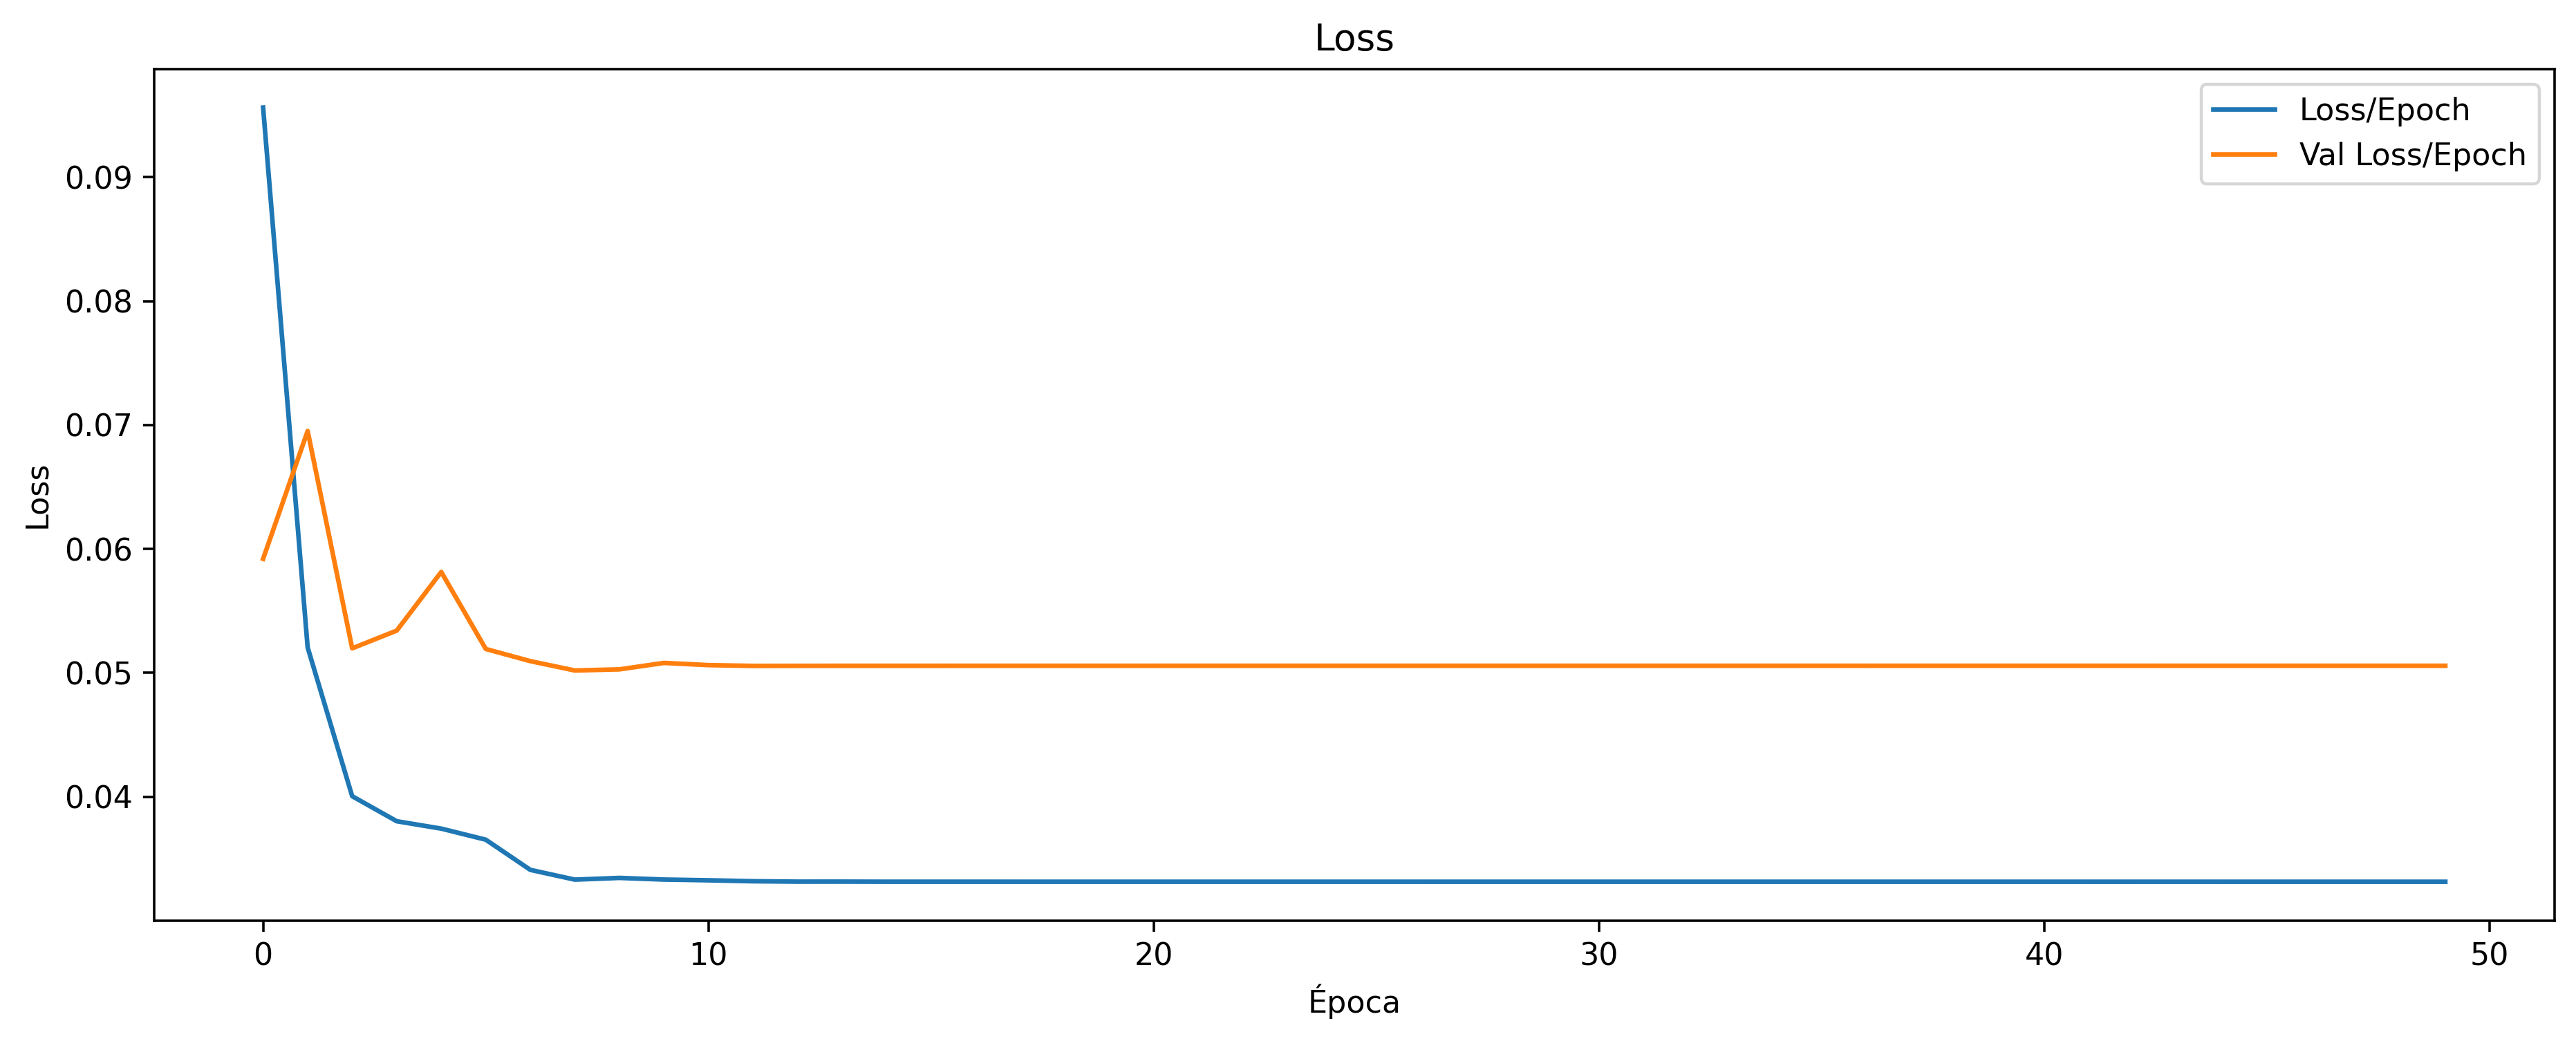

In [14]:
plot_history(history_model)

## Teste
### Carregando o Teste e executando a comparação entre original e predito

In [15]:
test = 'prev150_mucuri.txt'
X_test_all,y_test_all = carregar_tabela(test)
y_test_all = y_test_all.reshape(-1,1)
X_test_scaled = scaler_x.transform(X_test_all)
y_test_scaled = scaler_y.transform(y_test_all)

In [16]:
predito = model.predict(X_test_scaled, verbose=1)

6/6 [==============================] - 1s 86ms/step


In [17]:
predito_normal = scaler_y.inverse_transform(predito)

### Calculando o intervalo de confiança do erro de predição do modelo

In [18]:
def get_error_interval(model, X_val, Y_val, X_test, Y_test, y_test_pred, p_value):
    y_val_pred = model.predict(X_val)
    y_val_error = np.abs(Y_val - y_val_pred)
    error_quantile=np.ndarray((1,Y_val.shape[1]));
    for i in range(Y_val.shape[1]):
        error_quantile[0,i] = np.quantile(y_val_error[:,i], q=p_value, method='linear')
        
    y_test_interval_pred_left=np.ndarray(y_test_pred.shape);
    y_test_interval_pred_right=np.ndarray(y_test_pred.shape);
    
    for i in range(y_test_pred.shape[1]):
        y_test_interval_pred_left[:,i] = y_test_pred[:,i] - error_quantile[0,i]
        y_test_interval_pred_right[:,i] = y_test_pred[:,i] + error_quantile[0,i]
    return error_quantile, y_test_interval_pred_left, y_test_interval_pred_right

In [19]:
def get_mean_left_right_error_interval(model, y_scaler, y_test_pred):
    error, error_left, error_right = get_error_interval(model, X_val, y_val, X_test_scaled, y_test_scaled, y_test_pred, 0.95)
    
    error_left_normal = y_scaler.inverse_transform(error_left)
    error_right_normal = y_scaler.inverse_transform(error_right)

    mean_error_normal=np.ndarray((1,y_test_all.shape[1]));
    mean_error_left_normal=np.ndarray((1,y_test_all.shape[1]));
    mean_error_right_normal=np.ndarray((1,y_test_all.shape[1]));
    mean_predictions=np.ndarray((1,y_test_pred.shape[1]));

    for i in range(y_test_all.shape[1]):
        mean_error_left_normal[0,i] = np.mean(error_left_normal[:,i])
        mean_error_right_normal[0,i] = np.mean(error_right_normal[:,i])
        mean_predictions[0,i]=np.mean(y_test_pred[:,i])

    mean_error_normal=(mean_error_right_normal-mean_error_left_normal)/2
    return mean_predictions, mean_error_normal, mean_error_left_normal, mean_error_right_normal

In [20]:
mean_predictions, mean_error_normal, mean_error_left_normal, mean_error_right_normal = get_mean_left_right_error_interval(
    model, scaler_y, predito_normal)


### Plotando os gráficos de predição versus observado no teste, junto com as métricas

### Função de Estatística

In [21]:
def factor_of_2(y_true, y_pred):
    min_ = 0.5
    max_ = 2.0

    tensor_true = tf.constant(y_true)
    tensor_true = tf.cast(tensor_true, tf.float32)
    tensor_pred = tf.constant(y_pred)
    tensor_pred = tf.cast(tensor_pred, tf.float32)

    division = tf.divide(tensor_pred, tensor_true)

    greater_min = tf.greater_equal(division, min_)
    less_max = tf.less_equal(division, max_)

    res = tf.equal(greater_min, less_max)
    res = tf.cast(res, tf.float32)

    return backend.get_value(tf.reduce_mean(res))


def allmetrics(original,predito):
    r_value = 0
    slope, intercept, r_value, p_value, std_err = stats.linregress(original, predito)
    mse = mean_squared_error(original, predito)
    mae = mean_absolute_error(original, predito)
    rr = r2_score(original,predito)
    pea = stats.pearsonr(original, predito)
    fat = factor_of_2(original,predito)
    nmse = mse/stats.tvar(original)
    rmse = sqrt(mse)
    nrmse = rmse/stats.tstd(original)
    return mae,mse,nmse,r_value,rr,fat,rmse,nrmse

In [22]:
def get_plot_prediction_versus_observed(model):
    valores = []
    for i in range(y_test_all.shape[1]):
        mae,mse,nmse,r_value,rr,fat,rmse,nrmse = allmetrics(y_test_all[:,i],predito_normal[:,i])
        valores.append([str(i+1)+" hora",mae,mse,nmse,rmse,nrmse,r_value,rr,fat,mean_error_normal[0,i],mean_error_left_normal[0,i],mean_predictions[0,i],mean_error_right_normal[0,i]])
        print("MAE:",mae)
        print("MSE:",mse)
        print("NMSE:",nmse)
        print("RMSE:",rmse)
        print("NRMSE:",nrmse)
        print("R:",r_value)
        print("R²:",rr)
        print("Fator de 2:",fat)

        plt.figure(figsize=(20,5), dpi=320, facecolor='w', edgecolor='k')
        plt.title("Previsão do vento para "+str(i+1)+" hora(s) à frente")
        plt.xlabel("Amostras")
        plt.ylabel("Velocidade do Vento (m/s)")
        plt.plot(predito_normal[:,i], label="Predito", color='blue')
        plt.fill_between(range(predito_normal.shape[0]), predito_normal[:,i]-mean_error_normal[0,i], predito_normal[:,i]+mean_error_normal[0,i], color='blue', alpha=0.05)
        plt.plot(y_test_all[:,i], label="Original", color='orange')
        plt.legend()
        plt.show()
    erros = pd.DataFrame(valores)
    erros.columns = ['Horas à frente','MAE','MSE','NMSE','RMSE','NRMSE','R','R²','Fator de 2', 'error interval (+/-)', 'left limit', 'mean', 'right limit']
    erros = erros.set_index('Horas à frente')
    erros.loc['Média'] = erros.mean()
    return erros;


MAE: 0.8817709581875641
MSE: 1.2374530000947759
NMSE: 0.1743133553793149
RMSE: 1.112408647977341
NRMSE: 0.41750850934958783
R: 0.9115836797074878
R²: 0.8247692059081624
Fator de 2: 1.0


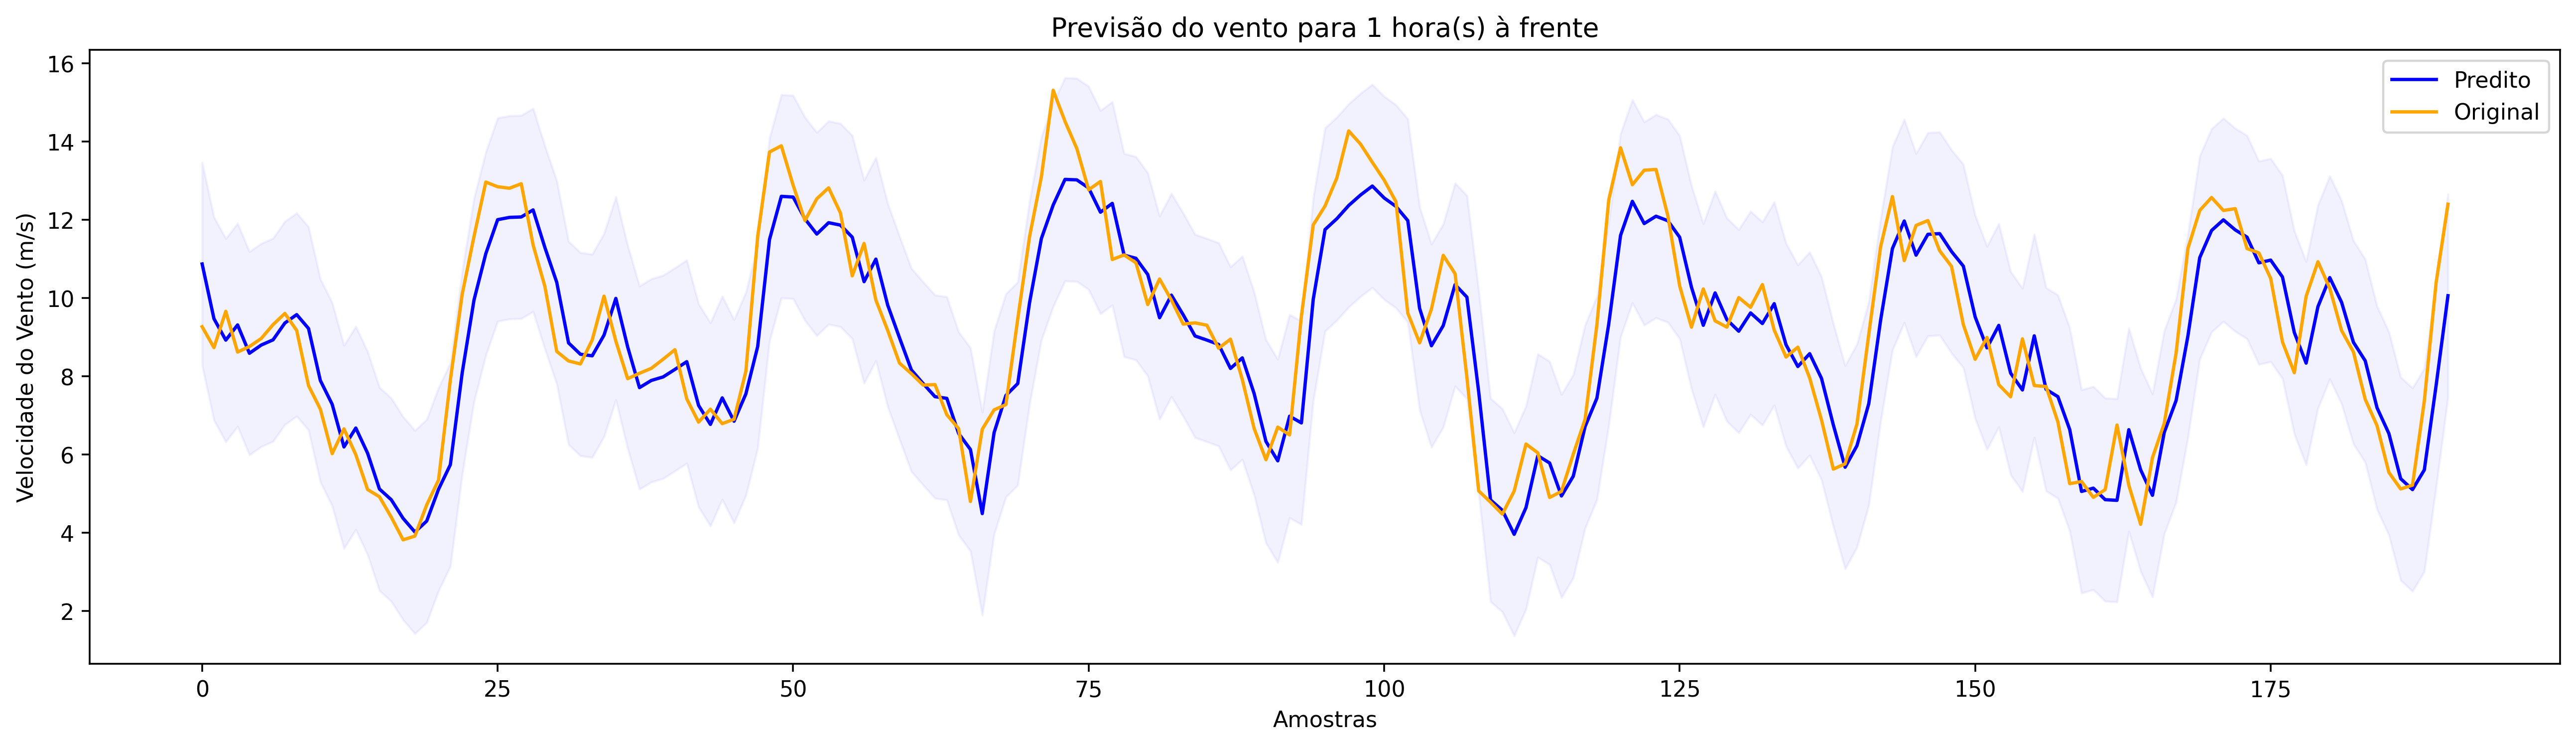

,MAE,MSE,NMSE,RMSE,NRMSE,R,R²,Fator de 2,error interval (+/-),left limit,mean,right limit
Horas à frente,,,,,,,,,,,,
1 hora,0.881771,1.237453,0.174313,1.112409,0.417509,0.911584,0.824769,1.0,2.59839,59.898138,8.916351,65.094918
Média,0.881771,1.237453,0.174313,1.112409,0.417509,0.911584,0.824769,1.0,2.59839,59.898138,8.916351,65.094918


In [23]:
erros_pd=get_plot_prediction_versus_observed(model)
erros_pd

### Função para verificar se as predições de dois modelos diferentes sobre o mesmo dataset possui diferença estatística, i.e. são equivalentes ou diferentes

In [24]:
from scipy.stats import wilcoxon
# sources: 
#   https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.wilcoxon.html
#   https://pythonfordatascienceorg.wordpress.com/wilcoxon-sign-ranked-test-python/
#   https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/
# em resumo: o teste de Wilcoxon signed-rank testa a hipótese nula de que duas amostras pareadas relacionadas vêm da mesma distribuição. Ela é não paramétrica.
def verify_distribution_wilcoxtest(data1, data2, p_H0):
    stat, p = wilcoxon(data1, data2)
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    if p > p_H0:
        print('Same distribution (fail to reject H0)')
    else:
        print('Different distribution (reject H0)')
    return stat, p

### Verificando se há diferença estatística entre o observado e o predito

In [25]:
verify_distribution_wilcoxtest(y_test_all[:,0],predito_normal[:,0], 0.05)

Statistics=7609.000, p=0.042
Different distribution (reject H0)


(7609.0, 0.04155891055025171)

### Criando novo modelo e verificando se suas predições têm ou não diferença estatística entre o modelo anterior

In [26]:
n_layers = 6
weight_shapes = {"weights_1": (n_layers,5,3)}

sampl_weights = np.random.uniform(low=0, high=np.pi, size=weight_shapes["weights_1"])
sampl_input = np.random.uniform(low=0, high=np.pi, size=(5,))
print(qml.draw(qnode, expansion_strategy="device")(sampl_input, sampl_weights))

0: ──H──RY(1.97)─╭●──Rot(1.84,2.86,0.80)──────────────────────╭●──Rot(1.40,2.07,2.57)
1: ──H──RY(0.45)─╰X─╭●────────────────────Rot(0.49,3.05,2.61)─╰X─╭●──────────────────
2: ──H──RY(0.56)─╭●─╰X────────────────────Rot(1.82,0.52,3.02)─╭●─╰X──────────────────
3: ──H──RY(0.21)─╰X─╭●────────────────────Rot(1.08,2.28,0.16)─╰X─╭●──────────────────
4: ──H──RY(0.93)────╰X────────────────────Rot(2.48,0.55,2.94)────╰X──────────────────

───────────────────────╭●──Rot(1.83,0.52,0.08)──────────────────────╭●──Rot(2.17,2.28,2.39)
───Rot(0.86,0.85,0.33)─╰X─╭●────────────────────Rot(1.54,1.46,1.12)─╰X─╭●──────────────────
───Rot(0.87,0.93,2.80)─╭●─╰X────────────────────Rot(0.03,1.92,0.46)─╭●─╰X──────────────────
───Rot(0.32,2.66,2.05)─╰X─╭●────────────────────Rot(0.88,1.32,0.94)─╰X─╭●──────────────────
───Rot(1.85,1.21,1.02)────╰X────────────────────Rot(0.32,0.80,0.78)────╰X──────────────────

───────────────────────╭●──Rot(0.47,1.45,2.86)──────────────────────╭●──Rot(2.72,2.57,0.31)
───Rot(1.39,0.54

In [27]:
q_layer2 = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=n_qubits)

model2 = tf.keras.models.Sequential([q_layer2,Activation, output_layer])
model2.compile(opt, loss="mse")
model2.build(input_shape)
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (5, 5)                    90        
                                                                 
 activation (Activation)     (5, 5)                    0         
                                                                 
 dense (Dense)               (5, 1)                    6         
                                                                 
Total params: 96
Trainable params: 96
Non-trainable params: 0
_________________________________________________________________


In [28]:
history_model2 = model2.fit(X_train, y_train, epochs=50, batch_size=64, callbacks=[re], verbose=1, validation_data=(X_val, y_val))

Epoch 1/50
7/7 [==============================] - 498s 71s/step - loss: 0.1084 - val_loss: 0.1142 - lr: 1.0000e-05
Epoch 2/50
7/7 [==============================] - 500s 71s/step - loss: 0.1078 - val_loss: 0.1137 - lr: 1.0000e-05
Epoch 3/50
7/7 [==============================] - 492s 70s/step - loss: 0.1071 - val_loss: 0.1131 - lr: 1.0000e-05
Epoch 4/50
7/7 [==============================] - 491s 70s/step - loss: 0.1065 - val_loss: 0.1126 - lr: 1.0000e-05
Epoch 5/50
7/7 [==============================] - 490s 70s/step - loss: 0.1059 - val_loss: 0.1121 - lr: 1.0000e-05
Epoch 6/50
7/7 [==============================] - 491s 70s/step - loss: 0.1053 - val_loss: 0.1116 - lr: 1.0000e-05
Epoch 7/50
7/7 [==============================] - 495s 71s/step - loss: 0.1048 - val_loss: 0.1112 - lr: 1.0000e-05
Epoch 8/50
7/7 [==============================] - 488s 69s/step - loss: 0.1044 - val_loss: 0.1108 - lr: 1.0000e-05
Epoch 9/50
7/7 [==============================] - 484s 69s/step - loss: 0.1039 -

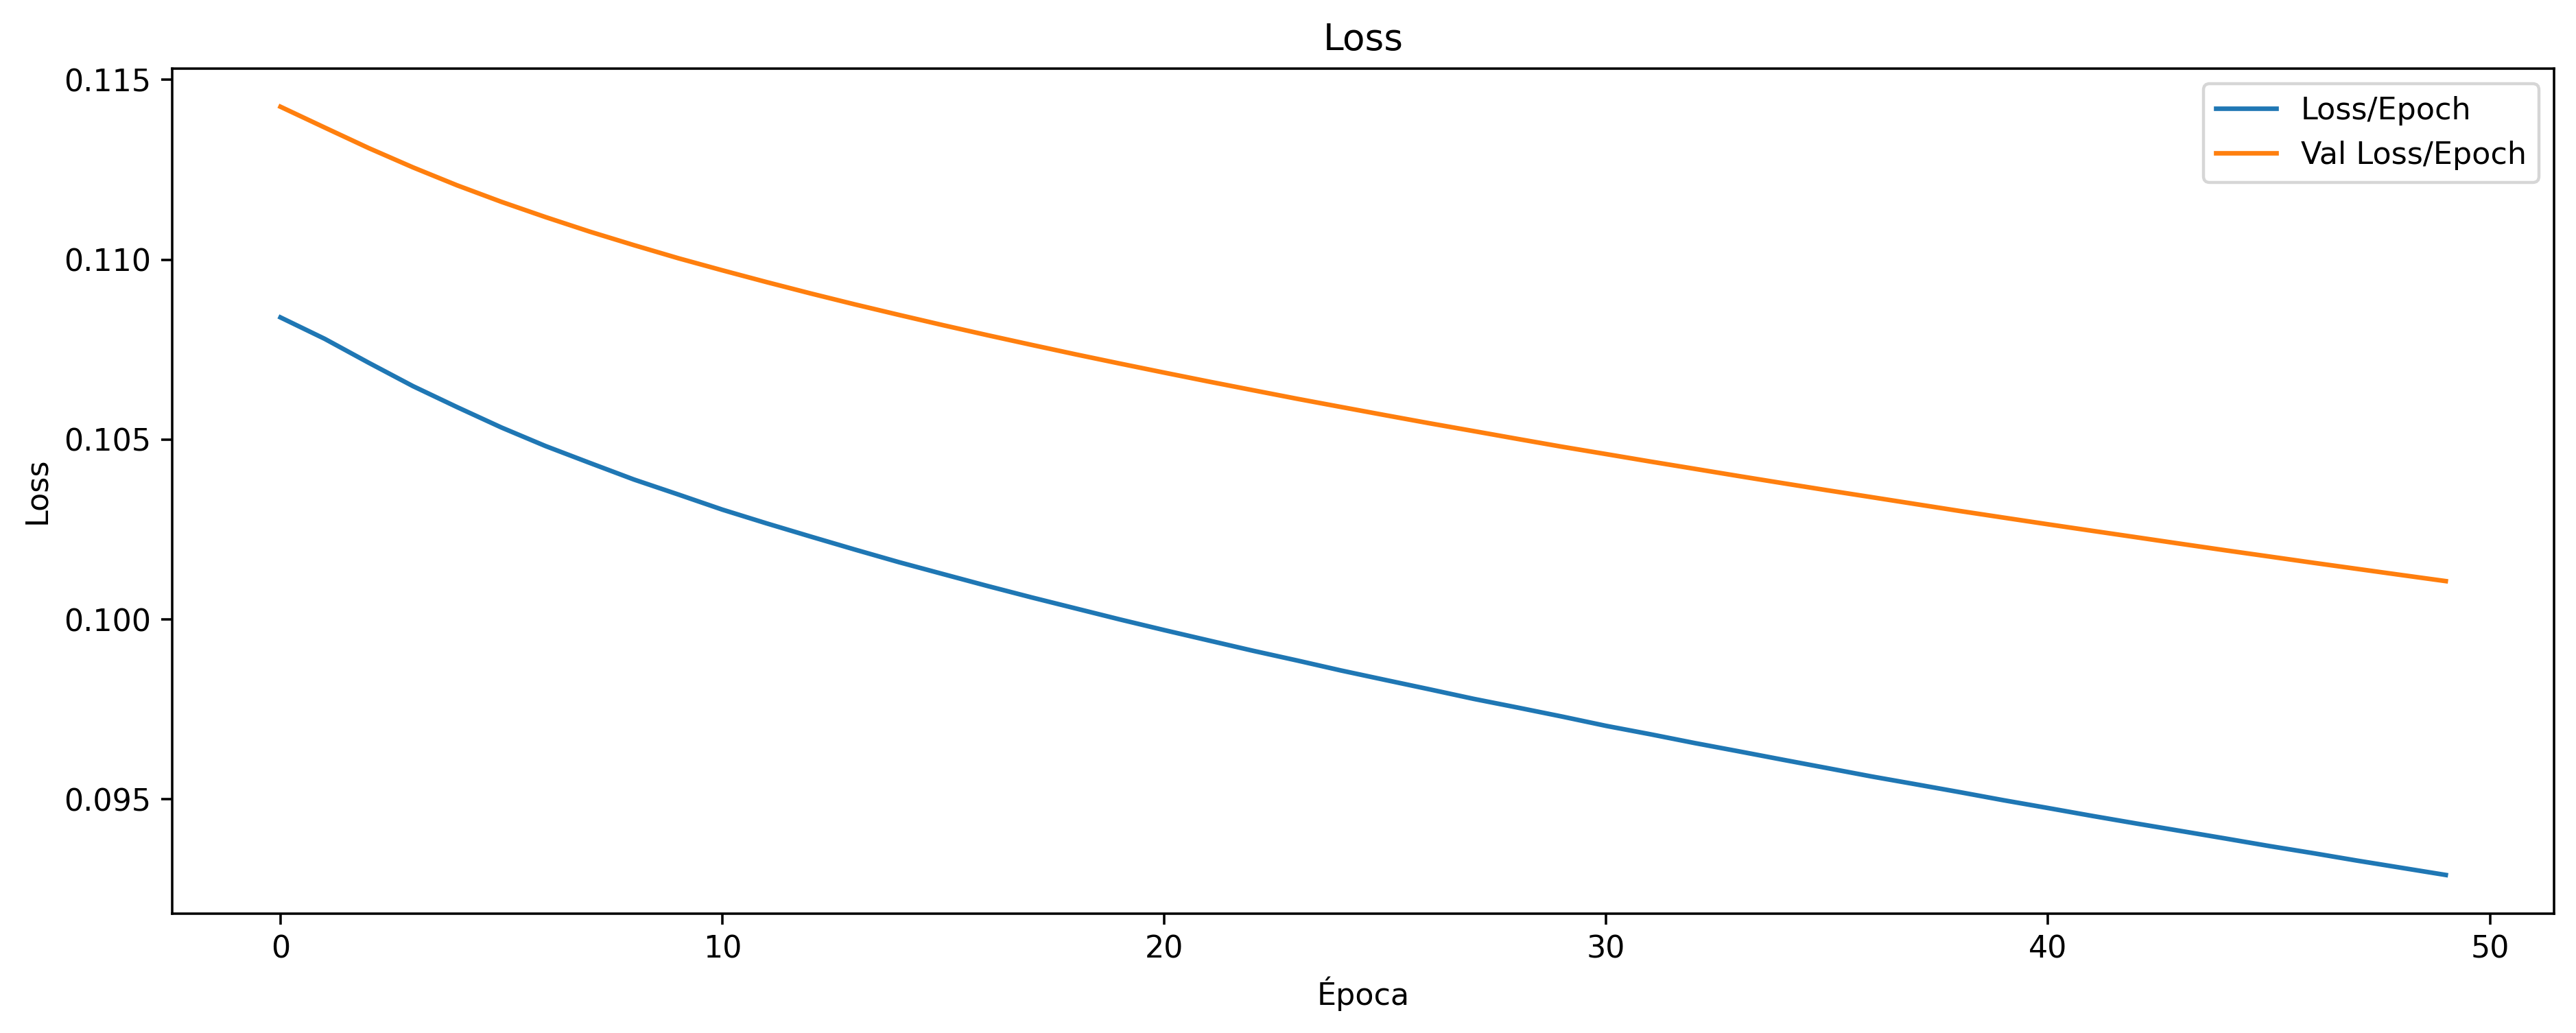

In [29]:
predito2 = model2.predict(X_test_scaled)
predito2_normal = scaler_y.inverse_transform(predito2)
plot_history(history_model2)

In [30]:
verify_distribution_wilcoxtest(predito_normal[:,0],predito2_normal[:,0], 0.05)

Statistics=381.000, p=0.000
Different distribution (reject H0)


(381.0, 1.5462041953956112e-30)

MAE: 0.8817709581875641
MSE: 1.2374530000947759
NMSE: 0.1743133553793149
RMSE: 1.112408647977341
NRMSE: 0.41750850934958783
R: 0.9115836797074878
R²: 0.8247692059081624
Fator de 2: 1.0


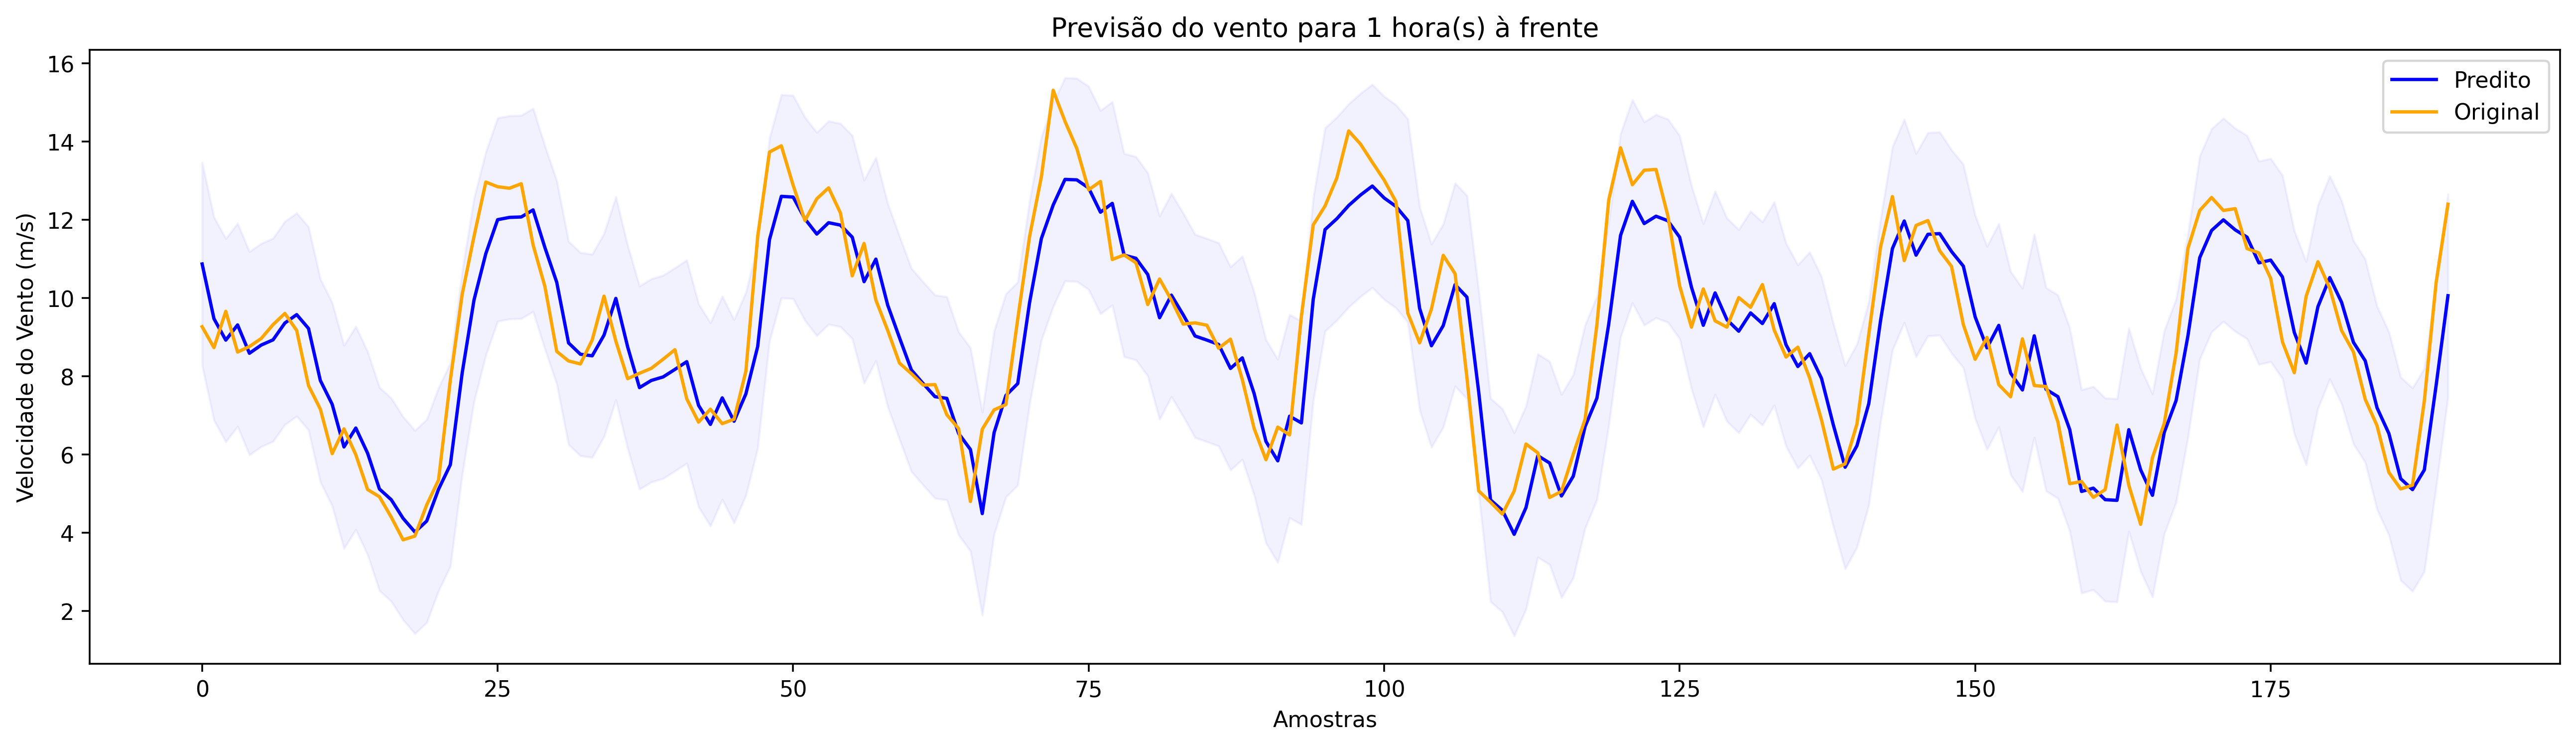

,MAE,MSE,NMSE,RMSE,NRMSE,R,R²,Fator de 2,error interval (+/-),left limit,mean,right limit
Horas à frente,,,,,,,,,,,,
1 hora,0.881771,1.237453,0.174313,1.112409,0.417509,0.911584,0.824769,1.0,2.59839,59.898138,8.916351,65.094918
Média,0.881771,1.237453,0.174313,1.112409,0.417509,0.911584,0.824769,1.0,2.59839,59.898138,8.916351,65.094918


In [31]:
erros2_pd=get_plot_prediction_versus_observed(model2)
erros2_pd